## Incorporate a seasonal dependence on Mn concentrations in runoff

For one of the experiments in this study, we test how significant incorporating a seasonal cycle in runoff Mn concentrations is. This is based on Colombo et al.'s estimates of potential maximum Mn concentrations during peak flow (in Colombo et al., 2019). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc

%matplotlib inline

#### Parameters:

In [2]:
color_glac = '#0873b4'
color_cont = '#ab5c29'
color_other= '#757575'

In [3]:
# domain dimensions:
imin, imax = 1479, 2179
jmin, jmax = 159, 799

#### Functions

In [4]:
def runoff_scaling(Q_river):
    scaling_factor = np.zeros_like(Q_river)
    
    # Maximum annual discharge for each river:
    Q_ma_river = np.ma.masked_where(Q_river<=0, Q_river) # masked array where runoff is zero
    Q_ma_max   = np.ma.max(Q_ma_river[:,:,:], axis=0)    # highest season flow
    Q_ma_min   = np.ma.min(Q_ma_river[:,:,:], axis=0)    # low season flow
    Q_ma_max [Q_ma_max == 0]  = np.nan
    
    # Scaling factor is 1280 at peak discharge (Colombo et al, 2019) and should be 1 during low flow.
    # "high flow concentrations are 1280% higher than low flow Mn concentrations"
    scaling_factor = 11.8*(Q_ma_river - Q_ma_min)/(Q_ma_max - Q_ma_min)
    scaling_factor = scaling_factor + 1
    
    # where there is no river runoff, the scaling factor should be zero
    scaling_factor[:,np.isnan(Q_ma_max)] = 0.0
    
    return scaling_factor

In [12]:
def save_file(month, SPM_rivers, dMn_rivers):
    file_write = xr.Dataset(
        {'spm_rivers': (("y","x"), SPM_rivers), 
         'dmn_rivers': (("y","x"), dMn_rivers)}, 
        coords = {
            "y": np.zeros(2400),
            "x": np.zeros(1632),
        },
    )

    file_write.to_netcdf(f'/ocean/brogalla/GEOTRACES/data/paper2-forcing-files/river_seasonal_m{month:02}.nc')
    
    return

### Load files

Load runoff dataset used in ANHA12 from Paul Myers' group (http://knossos.eas.ualberta.ca/anha/anhatable.php)

In [13]:
file_model = nc.Dataset('/ocean/brogalla/GEOTRACES/data/runoff/ANHA12_runoff_monthly_combined_Dai_Trenberth_Bamber_y2015.nc')
model_lons  = np.array(file_model.variables['nav_lon'])
model_lats  = np.array(file_model.variables['nav_lat'])
model_river = np.array(file_model.variables['runoff'])

Runoff classification file:

In [14]:
rclass      = nc.Dataset('/ocean/brogalla/GEOTRACES/data/river_class-202005.nc','r')
river_class = rclass.variables['rclass']
river_class = np.array(river_class)

#### Calculations

In [7]:
river_scaling = runoff_scaling(model_river)

In [8]:
# if we assume that the rivers were sampled during low flow season, we can apply the scaling directly to it
dMn_glacier_characteristic     = 164e-9   * river_scaling 
dMn_continental_characteristic = 29.8e-9  * river_scaling
dMn_other_characteristic       = 2.2e-9   * river_scaling 

SPM_glacier_characteristic     = 261e-6   * river_scaling
SPM_continental_characteristic = 1.196e-5 * river_scaling
SPM_other_characteristic       = 4.08e-6  * river_scaling

In [9]:
dMn_rivers = np.zeros((12, river_class.shape[0], river_class.shape[1]))
SPM_rivers = np.zeros((12, river_class.shape[0], river_class.shape[1]))

for month in range(0,12):  
    
    dMn_rivers[month,:,:][river_class==1.0] = dMn_glacier_characteristic[month][river_class==1.0]
    dMn_rivers[month,:,:][river_class==2.0] = dMn_continental_characteristic[month][river_class==2.0]
    dMn_rivers[month,:,:][river_class==3.0] = dMn_other_characteristic[month][river_class==3.0]
    dMn_rivers[month,:,:][river_class==4.0] = dMn_other_characteristic[month][river_class==4.0]
    
    SPM_rivers[month,:,:][river_class==1.0] = SPM_glacier_characteristic[month][river_class==1.0]
    SPM_rivers[month,:,:][river_class==2.0] = SPM_continental_characteristic[month][river_class==2.0]
    SPM_rivers[month,:,:][river_class==3.0] = SPM_other_characteristic[month][river_class==3.0]
    SPM_rivers[month,:,:][river_class==4.0] = SPM_other_characteristic[month][river_class==4.0]
    
#     save_file(month, SPM_rivers, dMn_rivers)

Visualise some of the output:

Text(0.5, 0.98, 'Mean river Mn forcing climatology')

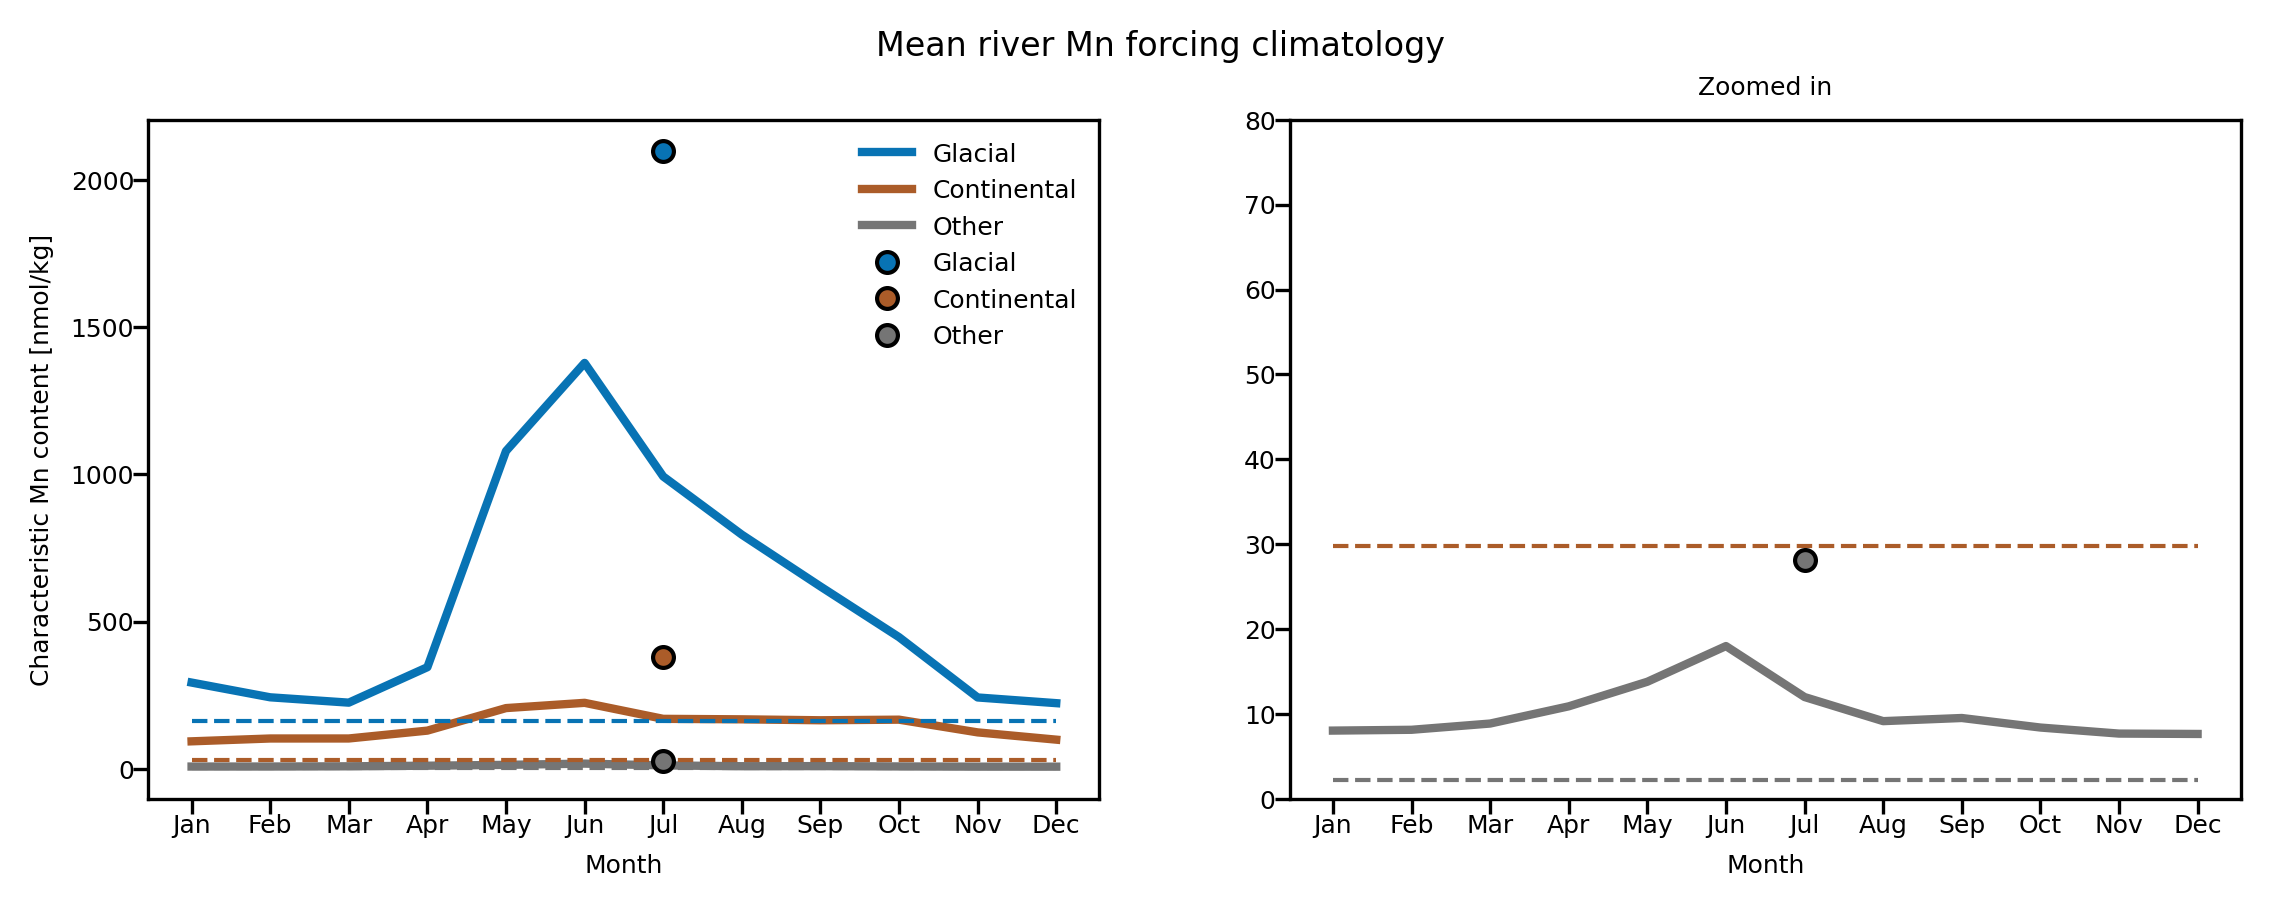

In [10]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(1,2, figsize=(9,3), dpi=300)

for axis in ax.ravel():
    axis.tick_params(axis='both', labelsize=6, pad=-0.1)

    axis.plot(months, np.mean(dMn_rivers[:,river_class==1.0], axis=1)*1e9, '-', linewidth=2.0, c=color_glac, label='Glacial')
    axis.plot(months, np.mean(dMn_rivers[:,river_class==2.0], axis=1)*1e9, '-', linewidth=2.0, c=color_cont, label='Continental')
    axis.plot(months, np.mean(dMn_rivers[:,river_class==3.0], axis=1)*1e9, '-', linewidth=2.0, c=color_other, label='Other')

    axis.plot(months, np.ones(len(months))*164, '--', linewidth=1.0, c=color_glac)
    axis.plot(months, np.ones(len(months))*29.8, '--', linewidth=1.0, c=color_cont)
    axis.plot(months, np.ones(len(months))*2.2, '--', linewidth=1.0, c=color_other)

    axis.plot(6, np.max(dMn_rivers[:,river_class==1.0])*1e9, '.', c=color_glac, label='Glacial', markeredgecolor='k', markersize=10)
    axis.plot(6, np.max(dMn_rivers[:,river_class==2.0])*1e9, '.', c=color_cont, label='Continental', markeredgecolor='k', markersize=10)
    axis.plot(6, np.max(dMn_rivers[:,river_class==3.0])*1e9, '.', c=color_other, label='Other', markeredgecolor='k', markersize=10)

    axis.set_xlabel('Month', fontsize=6)
    
ax[0].set_ylabel('Characteristic Mn content [nmol/kg]', fontsize=6)
ax[0].legend(frameon=False, fontsize=6)
ax[1].set_ylim([0,80])
ax[1].set_title('Zoomed in', fontsize=6)
fig.suptitle('Mean river Mn forcing climatology', fontsize=8)

Text(0.5, 0.98, 'Example river Mn forcing climatology')

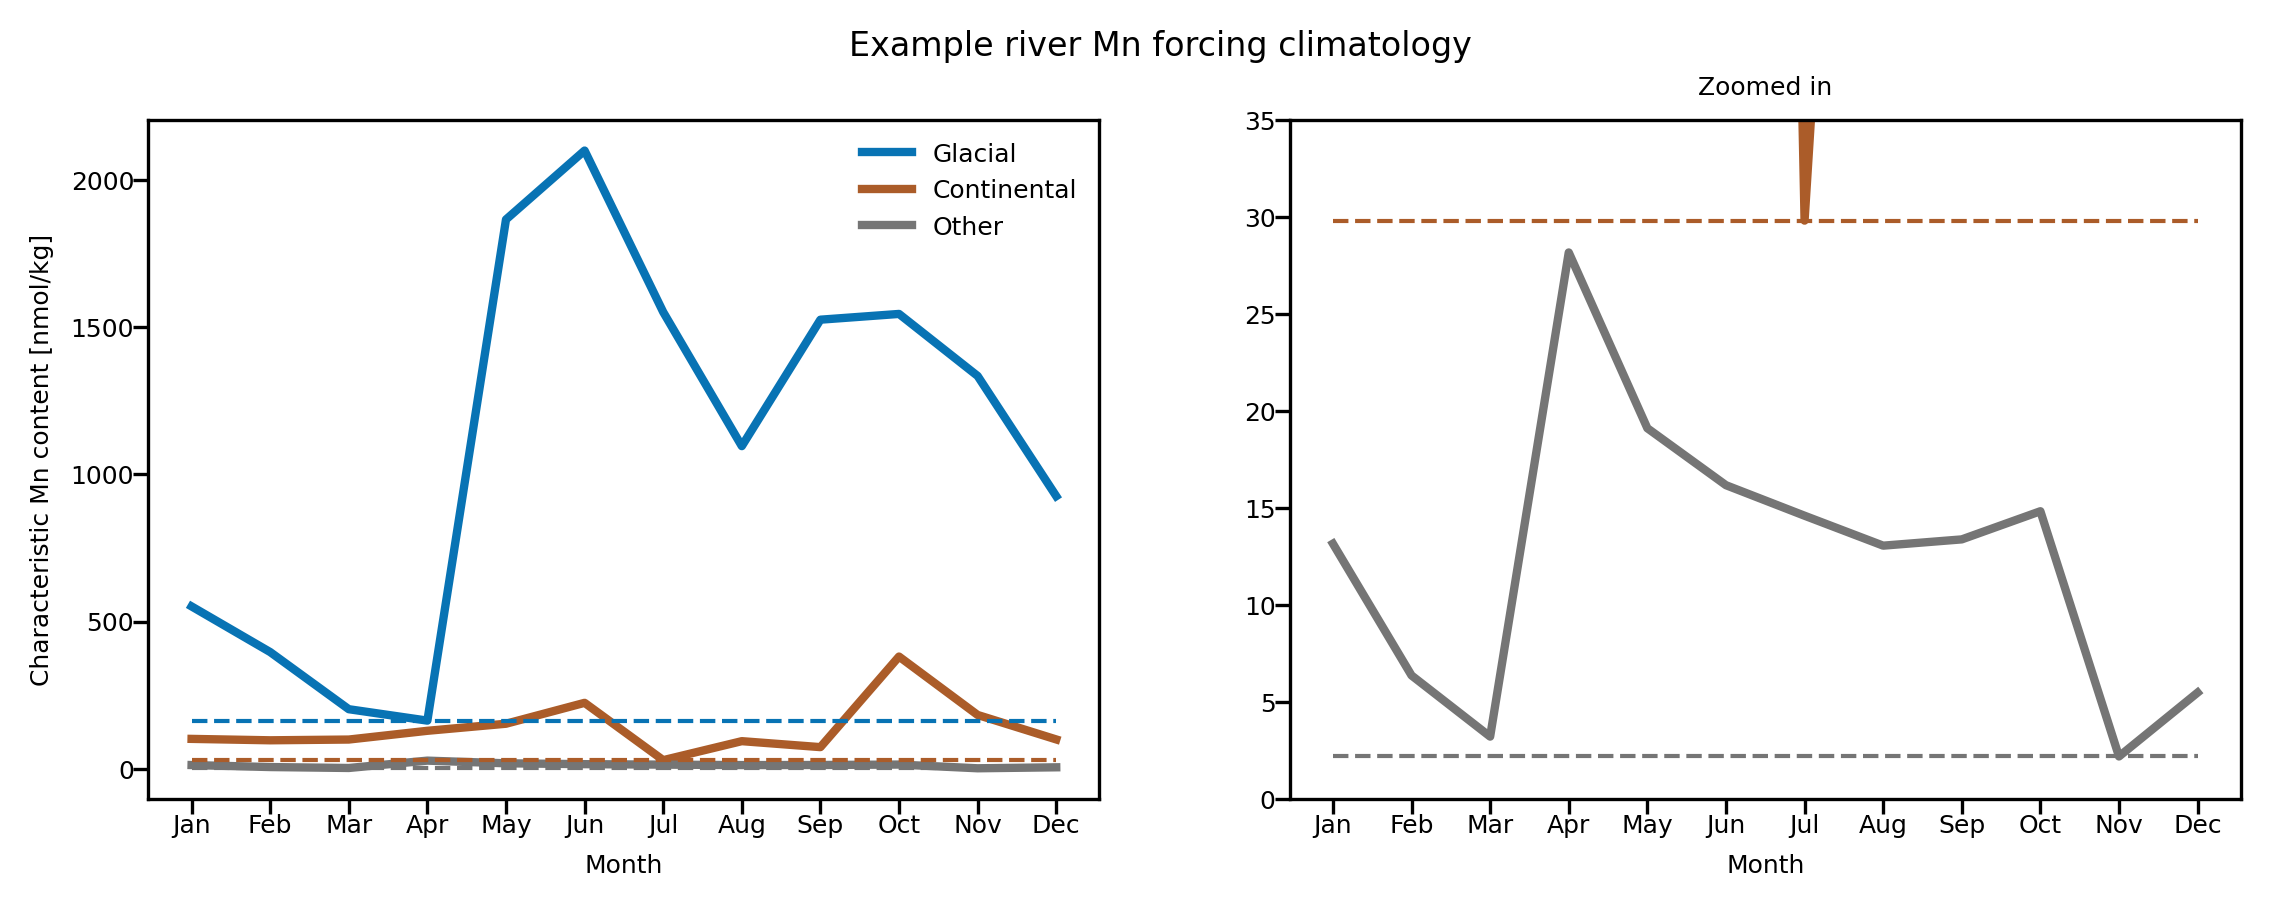

In [11]:
fig, ax = plt.subplots(1,2, figsize=(9,3), dpi=300)

for axis in ax.ravel():
    axis.tick_params(axis='both', labelsize=6, pad=-0.1)

    axis.plot(months, dMn_rivers[:,1045,1080]*1e9        , '-', linewidth=2.0, c=color_glac , label='Glacial')
    axis.plot(months, dMn_rivers[:,imin+699,jmin+323]*1e9, '-', linewidth=2.0, c=color_cont , label='Continental')
    axis.plot(months, dMn_rivers[:,8,1332]*1e9           , '-', linewidth=2.0, c=color_other, label='Other')

    axis.plot(months, np.ones(len(months))*164, '--', linewidth=1.0, c=color_glac)
    axis.plot(months, np.ones(len(months))*29.8, '--', linewidth=1.0, c=color_cont)
    axis.plot(months, np.ones(len(months))*2.2, '--', linewidth=1.0, c=color_other)

    axis.set_xlabel('Month', fontsize=6)
    
ax[0].set_ylabel('Characteristic Mn content [nmol/kg]', fontsize=6)
ax[0].legend(frameon=False, fontsize=6)
ax[1].set_ylim([0,35])
ax[1].set_title('Zoomed in', fontsize=6)
fig.suptitle('Example river Mn forcing climatology', fontsize=8)